First contact with observations: convolution, clip, interpolation, comparison with MILES SSP spectra

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)

(3401, 3)


(5500.0, 6500.0)

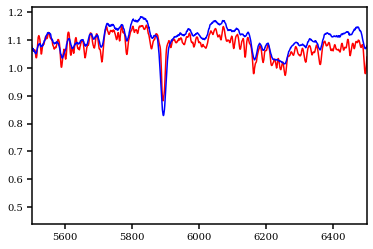

In [ ]:
file='./obs/stack_100.00_110.00_skyup.dat' #less massive, younger
file2='./obs/stack_280.00_320.00_skyup.dat' #more massive, older

data=np.loadtxt(file)
data2=np.loadtxt(file2)

print(np.shape(data))
wave=data[:,0]
flux=data[:,1]

wave2=data2[:,0]
flux2=data2[:,1]
plt.plot(wave,flux/np.mean(flux),'r')
plt.plot(wave2,flux2/np.mean(flux2),'b')
plt.xlim(5500,6500)

In [ ]:
import os

files= sorted(os.listdir('obs'))
waves=[]
fluxes=[]
sigma_gal=[]
for f in files:
    data=np.loadtxt('./obs/'+f)
    waves.append(data[:,0])
    fluxes.append(data[:,1])
    arr=np.array([float(f[6:12]),float(f[13:19])])
    sigma_gal.append(np.mean(arr))

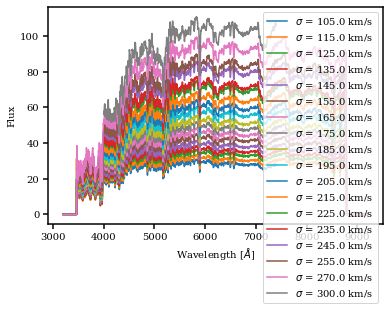

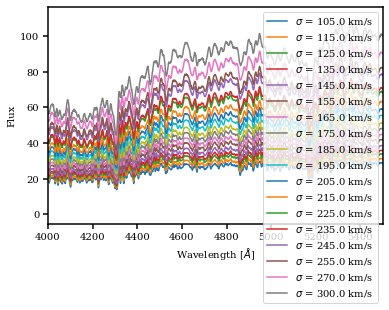

In [ ]:
n=len(fluxes)

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend(fontsize=10)
plt.show()


"""for i in range(n):
    print(np.min(waves[i]),np.max(waves[i]))"""

#largest wavelength range from 4000 to 7400 but we will limit ourselves to the range from 4000 to 5500"

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.xlim(4000,5500)
plt.legend(fontsize=10)
plt.show()


In [ ]:
fluxes_short=[]
waves_short=[]

for i in range(n):
    ind=np.where((waves[i]>3999)&(waves[i]<7401))[0]
    fluxes_short.append(fluxes[i][ind])
    waves_short.append(waves[i][ind])

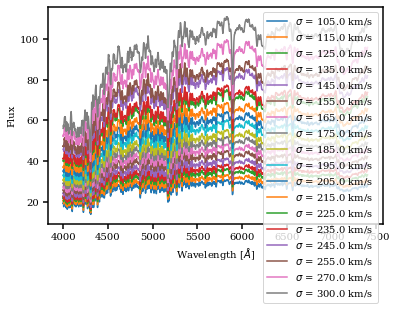

In [ ]:
for i in range(n):
    plt.plot(waves_short[i],fluxes_short[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')

plt.legend(fontsize=10)
plt.show()

In [ ]:
def gaussian_filter1d(spec, sig):
    """
    Convolve a spectrum by a Gaussian with different sigma for every pixel.
    If all sigma are the same this routine produces the same output as
    scipy.ndimage.gaussian_filter1d, except for the border treatment.
    Here the first/last p pixels are filled with zeros.
    When creating  template library for SDSS data, this implementation
    is 60x faster than a naive for loop over pixels.
    :param spec: vector with the spectrum to convolve
    :param sig: vector of sigma values (in pixels) for every pixel
    :return: spec convolved with a Gaussian with dispersion sig
    """
    sig = sig.clip(0.01)  # forces zero sigmas to have 0.01 pixels
    p = int(np.ceil(np.max(3*sig)))
    m = 2*p + 1  # kernel size
    x2 = np.linspace(-p, p, m)**2
    n = spec.size
    a = np.zeros((m, n))
    for j in range(m):   # Loop over the small size of the kernel
        a[j, p:-p] = spec[j:n-m+j+1]
    gau = np.exp(-x2[:, None]/(2*sig**2))
    gau /= np.sum(gau, 0)[None, :]  # Normalize kernel
    conv_spectrum = np.sum(a*gau, 0)
    return conv_spectrum

$$ \sigma_{gal}^2=\sigma_{v}^2+\sigma_{ins}^2$$

We are going to convert all of them to $v=300$ km/s, so:

$$ \sigma_{diff}^2 = \sigma_{300}^2+\sigma_{ins}^2 - (\sigma_{gal}^2+\sigma_{ins}^2) = \sigma_{300}^2 - \sigma_{gal}^2   $$

And to move from velocity dispersion to kernel width, we will need:

$$
\mathrm{FWHM}=2 \sqrt{2 \ln 2} \sigma \approx 2.35482 \sigma
$$

In [ ]:
cvel=300000 #km/s

"""for i in range(n):
    print(waves_short[i],waves_short[i][1]-waves_short[i][0]) #psize=1 A
"""
psize=1
fluxes_conv=[]
max_sigma=np.sqrt(300**2 - np.array(sigma_gal)**2) #velocity dispersion

for i in trange(n):
    FWHM_gal = 2.*np.sqrt(2.*np.log(2.)) * max_sigma[i] / cvel * waves_short[i]
    FWHM_dif = np.sqrt(FWHM_gal**2)
    sigma = FWHM_dif/(psize*2.*np.sqrt(2.*np.log(2.))) # Sigma difference in pixels, for the kernel
    flux_conv = gaussian_filter1d(fluxes_short[i], sigma) 
    fluxes_conv.append(flux_conv)

100%|██████████| 18/18 [00:00<00:00, 198.61it/s]


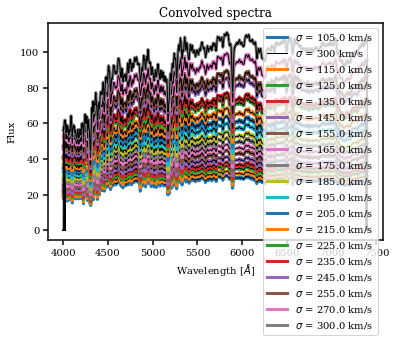

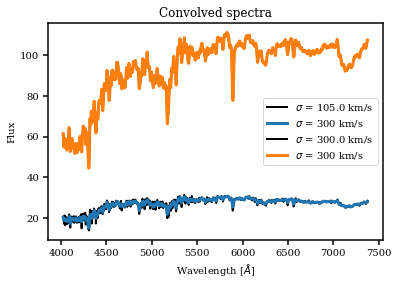

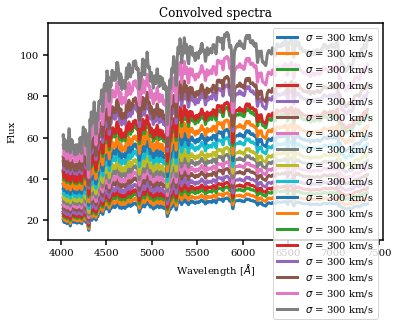

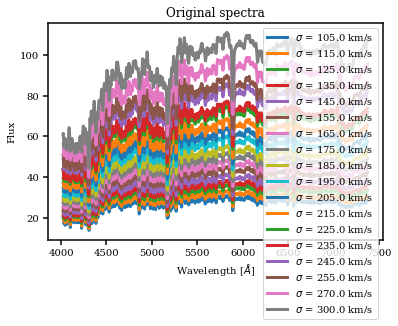

In [ ]:
for i in range(n): 
    plt.plot(waves_short[i],fluxes_short[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',lw=3)
    if i==0:
        plt.plot(waves_short[i],fluxes_conv[i],label='$\\sigma$ = '+str(300)+' km/s',c='k',lw=1)
    else:
        plt.plot(waves_short[i],fluxes_conv[i],c='k',lw=1)

plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()


for i in [0,-1]:
    plt.plot(waves_short[i][23:3378],fluxes_short[i][23:3378],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',c='k',lw=2)
    plt.plot(waves_short[i][23:3378],fluxes_conv[i][23:3378],label='$\\sigma$ = '+str(300)+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()


for i in range(n):
    plt.plot(waves_short[i][23:3378],fluxes_conv[i][23:3378],label='$\\sigma$ = '+str(300)+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()

for i in range(n):
    plt.plot(waves_short[i][23:3378],fluxes_short[i][23:3378],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Original spectra')
plt.legend(fontsize=10)
plt.show()

In [ ]:
#print(fluxes_conv[0][:20])
#print(waves_short[0][:20])
#print(fluxes_conv[0][-30:])
#print(waves_short[0][-30:])

print('First index non zero: ',np.where(fluxes_conv[0]>0)[0][0])
print('Last index non zero: ',np.where(fluxes_conv[0]>0)[0][-1])

print('First index non zero: ',np.where(fluxes_conv[-1]>0)[0][0])
print('Last index non zero: ',np.where(fluxes_conv[-1]>0)[0][-1])


print('Valid wavelength range: ', np.min(waves_short[0][23:3378]),np.max(waves_short[0][23:3378]))

waves_short_2 = []
fluxes_conv_2 = []

print('Selected wavelength range: ',waves_short[0][23],waves_short[0][2000])

for i in range(n):
    waves_short_2.append(waves_short[i][23:2001])
    fluxes_conv_2.append(fluxes_conv[i][23:2001])

First index non zero:  21
Last index non zero:  3379
First index non zero:  1
Last index non zero:  3399
Valid wavelength range:  4023.0 7377.0
Selected wavelength range:  4023.0 6000.0


In [ ]:
from astropy.io import fits

#we convolve MILES base models (base alpha_fe)
#We just load two SSP spectra as first test (both solar metallicity and young/old)
#FWMH=2.51A
path='../MILES/MILES_BASTI_KU_baseFe/'

old_spec='Mku1.30Zp0.06T14.0000_iTp0.00_baseFe.fits'
young_spec='Mku1.30Zp0.06T00.0300_iTp0.00_baseFe.fits'

hdul_o=fits.open(path+old_spec)
hdul_y=fits.open(path+young_spec)
spec_o=hdul_o[0].data
spec_y=hdul_y[0].data
hdr=hdul_o[0].header
wave = hdr['CRVAL1'] + np.arange(hdr['NAXIS1'])*hdr['CDELT1']

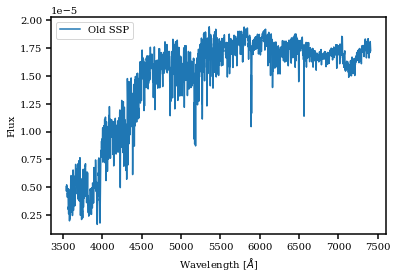

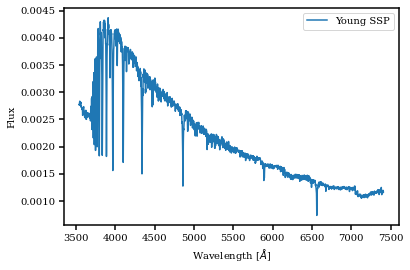

In [ ]:
plt.plot(wave,spec_o,label='Old SSP')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()

plt.plot(wave,spec_y,label='Young SSP')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()



We try to simulate in MILES spectra a velocity dispersion of $300$ km/s

$$\sigma_{diff}= \sigma_{300}**2 + \sigma_{ins}**2 - \sigma_{MILES}**2$$

where $FWMH_{MILES} = 2.51 A$ and as $R=\frac{\lambda}{\Delta \lambda} = \frac{c}{\sigma}$, then
$\sigma_{MILES}=\frac{\Delta \lambda \cdot c}{\lambda}$.


$\sigma_{ins}$ is instroduced by the SDSS instrument and we get it from SPIDER VIII paper (La Barbera 13)


In [ ]:
#convolution

cvel=300000 #km/s

psize=0.9 #miles delta lambda
fluxes_conv_miles=[]
sigma_miles=cvel * psize / wave #km/s



def fwhm(l): #units: amstrong, from LaBarbera13
    #valid only for l in [4000,6000] A
    if  l<5500:
        return 0.0001*l+1.75
    elif l>=5500:
        return 0.0014*l-5.4


fwhm_sdss=np.ones((len(wave)))

for i in range(len(wave)):
    fwhm_sdss[i]=fwhm(wave[i])


sigma_sdss=fwhm_sdss/(2.*np.sqrt(2.*np.log(2.)))  *cvel/wave  #units km/s


max_sigma=np.sqrt(300**2+sigma_sdss**2-sigma_miles**2)
FWHM_gal = 2.*np.sqrt(2.*np.log(2.)) * max_sigma / cvel * wave  #no units
FWHM_dif = np.sqrt(FWHM_gal**2)
sigma = FWHM_dif/(psize*2.*np.sqrt(2.*np.log(2.))) # Sigma difference in pixels (units A^-1)
spec_o_conv = gaussian_filter1d(spec_o, sigma)
spec_y_conv = gaussian_filter1d(spec_y, sigma)

[76.2604152  76.24103462 76.22166389 ... 36.44806825 36.44364058
 36.43921399]


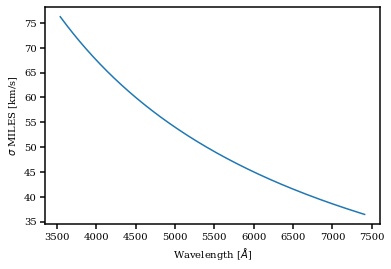

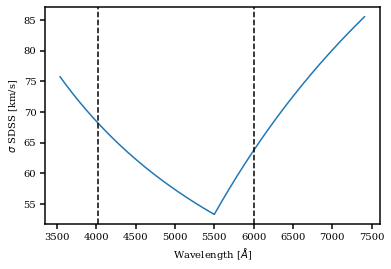

In [ ]:
#print(sigma_miles*2.35, '... it should be 2.51 A, the FWMH of MILES ') ???

print(sigma_miles)
plt.plot(wave,sigma_miles)
plt.ylabel('$\\sigma$ MILES [km/s]')
plt.xlabel('Wavelength [$\\AA$]')
plt.show()

plt.plot(wave,sigma_sdss)
plt.ylabel('$\\sigma$ SDSS [km/s]')
plt.xlabel('Wavelength [$\\AA$]')
plt.axvline(4023,0,1,ls='--',c='k')
plt.axvline(6000,0,1,ls='--',c='k')
plt.show()

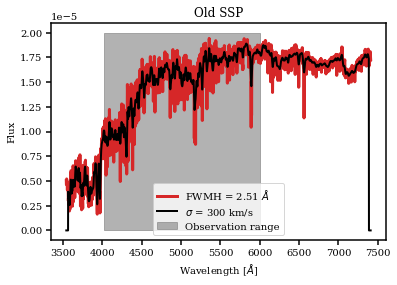

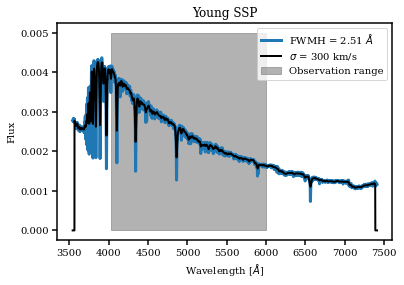

In [ ]:
plt.plot(wave,spec_o,label='FWMH = 2.51 $\AA$',lw=3,c='tab:red')
plt.plot(wave,spec_o_conv,label='$\\sigma$ = '+str(300)+' km/s',lw=2,c='k')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Old SSP')
plt.fill_betweenx([0,2e-5],4023,6000,label='Observation range',alpha=0.6,color='grey')
plt.legend()
plt.show()

plt.plot(wave,spec_y,label='FWMH = 2.51 $\AA$',lw=3,c='tab:blue')
plt.plot(wave,spec_y_conv,label='$\\sigma$ = '+str(300)+' km/s',lw=2,c='k')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Young SSP')
plt.fill_betweenx([0,0.005],4023,6000,label='Observation range',alpha=0.6,color='grey')
plt.legend()
plt.show()


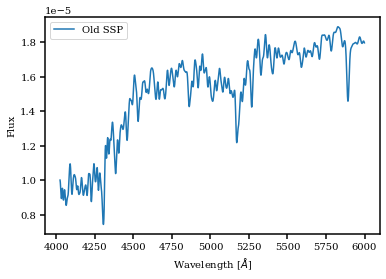

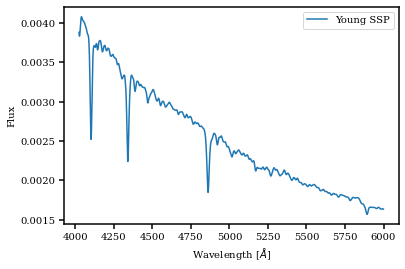

In [ ]:
#short range (with spectra already convolved)

ind=np.where((wave>4022.9)&(wave<6000.1))[0]
wave_short=wave[ind]
spec_o_short=spec_o_conv[ind]
spec_y_short=spec_y_conv[ind]

plt.plot(wave_short,spec_o_short,label='Old SSP')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()

plt.plot(wave_short,spec_y_short,label='Young SSP')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


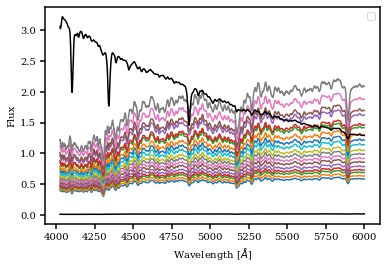

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


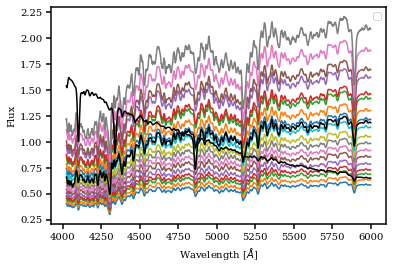

In [ ]:
#observations
for i in range(n):
    plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.mean(fluxes_conv_2))

#MILES
spec_short=np.array([spec_o_short,spec_y_short])
for i in range(2):
    plt.plot(wave_short,spec_short[i]/np.mean(spec_short),'k')

plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()

#observations
for i in range(n):
    plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.mean(fluxes_conv_2))

#MILES
spec_short=np.array([spec_o_short,spec_y_short])
for i in range(2):
    plt.plot(wave_short,spec_short[i]/np.mean(spec_short[i]),'k')

plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()

#seems ok, but we have a problem with the flux measure




In [ ]:
#we load all MILES spectra (all the ages for a fixed Z and alpha_fe)

def get_tbins(dir_name,strs_1,strs_2):
    library=os.listdir(dir_name)
    x,y=len(strs_1),len(strs_2)
    lib=[]
    lib_n=[]
    for i,j in enumerate(library):
        if j[:x]==strs_1:
            lib.append(j[x:y+1])
            lib_n.append(float(j[x:y+1]))     
    lib_n=np.array(sorted(lib_n))
    return lib_n

def get_data(dir_name,strs_1,strs_2):
    library=os.listdir(dir_name)
    x,y=len(strs_1),len(strs_2)
    lib=[]
    lib_n=[]
    for i,j in enumerate(library):
        if j[:x]==strs_1:
            lib.append(j[x:y+1])
            lib_n.append(float(j[x:y+1]))
        
    lib_n=np.array(lib_n)
    data=[]
    
    for j in range(len(lib_n)):
        globals() ['hdul'+str(j)]=fits.open(dir_name+'/'+strs_1+lib[j]+strs_2)
        data.append(np.array(globals()['hdul'+str(j)][0].data))

    hdr=hdul0[0].header
    wave = hdr['CRVAL1'] + np.arange(hdr['NAXIS1'])*hdr['CDELT1']
    
    ind_sorted=np.argsort(lib_n)
    data=np.array(data,ndmin=2)
    data=data[ind_sorted,:]
    lib_n=lib_n[ind_sorted]
    return wave,data


wave,data_MILES=get_data(dir_name='../MILES/MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
tbins=get_tbins(dir_name='../MILES/MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')

In [ ]:
#CONVOLVE ALL MILES SPECTRA

cvel=300000 #km/s
psize=0.9 #miles delta lambda
fluxes_conv_miles=[]
sigma_miles=cvel * psize / wave #km/s

def fwhm(l): #units: amstrong, from LaBarbera13
    #valid only for l in [4000,6000] A
    if  l<5500:
        return 0.0001*l+1.75
    elif l>=5500:
        return 0.0014*l-5.4

fwhm_sdss=np.ones((len(wave)))

for i in range(len(wave)):
    fwhm_sdss[i]=fwhm(wave[i])


sigma_sdss=fwhm_sdss/(2.*np.sqrt(2.*np.log(2.)))

max_sigma=np.sqrt(300**2+sigma_sdss**2-sigma_miles**2)
FWHM_gal = 2.*np.sqrt(2.*np.log(2.)) * max_sigma / cvel * wave
FWHM_dif = np.sqrt(FWHM_gal**2)
sigma = FWHM_dif/(psize*2.*np.sqrt(2.*np.log(2.))) # Sigma difference in pixels


spec_conv=[]
for i in range(len(data_MILES)):
    spec_conv.append(gaussian_filter1d(data_MILES[i], sigma))

ind=np.where((wave>4022.9)&(wave<6000.1))[0]
wave_short=wave[ind]

spec_conv_short=[]
for i in range(len(data_MILES)):
    spec_conv_short.append(spec_conv[i][ind])



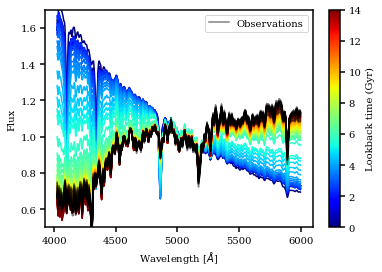

In [ ]:


#MILES
colors=plt.cm.jet(np.linspace(0,1,len(tbins)))
for i in range(len(spec_conv_short)):
    plt.plot(wave_short,spec_conv_short[i]/np.median(spec_conv_short[i]),color=colors[i])
    plt.scatter(wave_short,spec_conv_short[i],marker='None',c=tbins[i]*np.ones(len(wave_short)),cmap='jet')
    
#observations
for i in range(n):
    if i==0:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k',label='Observations',alpha=0.5)
    else:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k',alpha=0.5)
        
    
        
plt.colorbar(label='Lookback time (Gyr)')
plt.clim(0,14)
plt.ylim(0.5,1.7)
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()

#observations are really old galaxies as we see

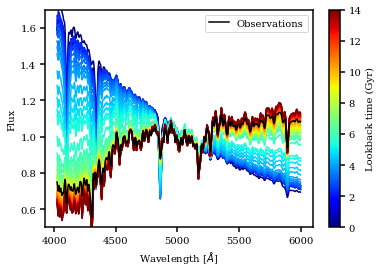

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


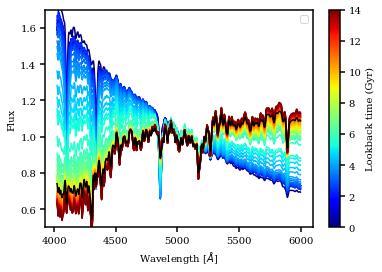

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


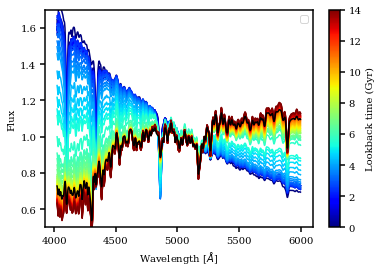

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


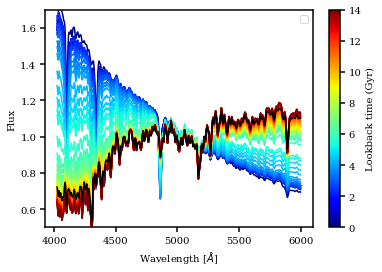

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


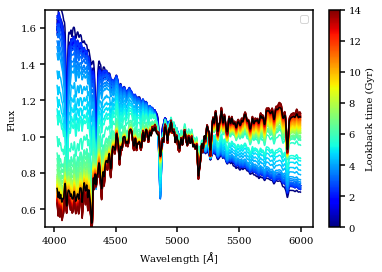

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


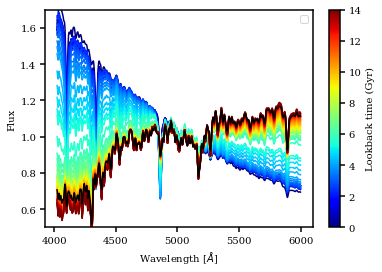

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


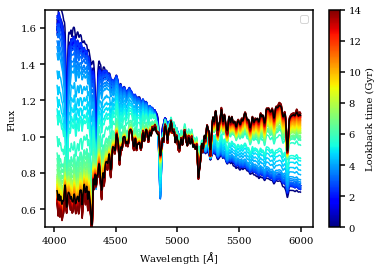

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


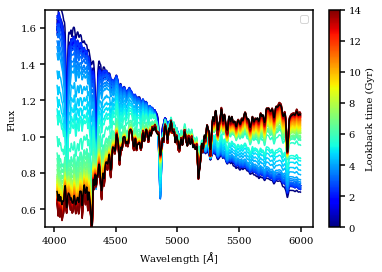

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


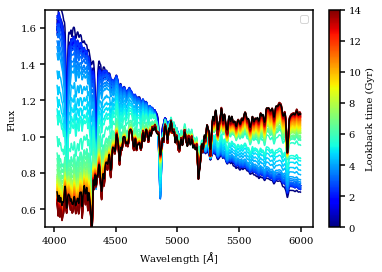

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


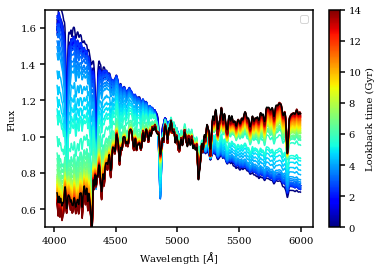

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


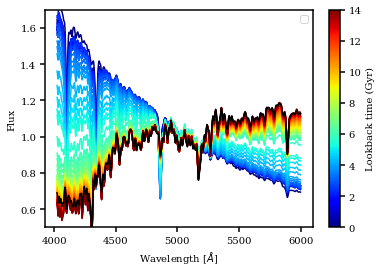

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


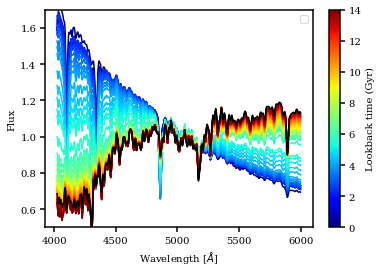

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


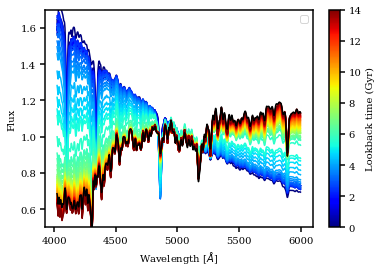

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


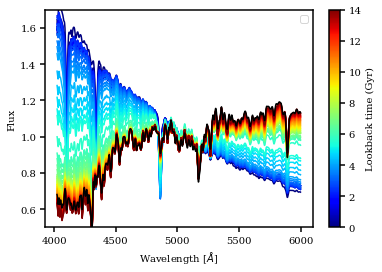

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


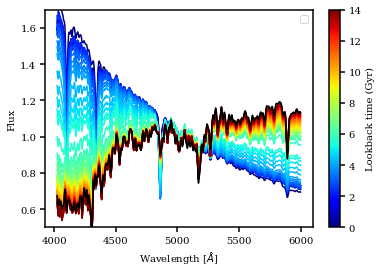

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


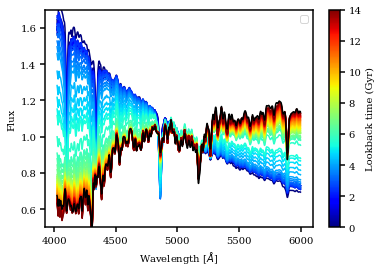

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


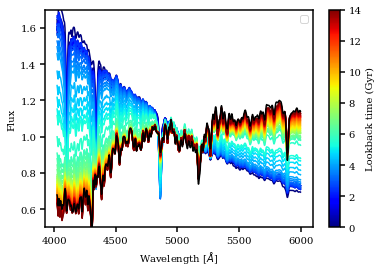

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


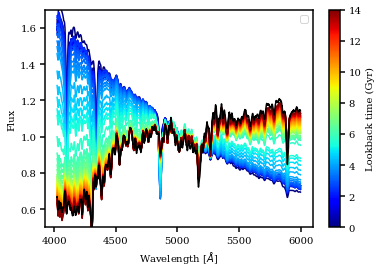

In [21]:
#single observation each time


    
#observations
for i in range(n):
    
    #MILES
    colors=plt.cm.jet(np.linspace(0,1,len(tbins)))
    for j in range(len(spec_conv_short)):
        plt.plot(wave_short,spec_conv_short[j]/np.median(spec_conv_short[j]),color=colors[j])
        plt.scatter(wave_short,spec_conv_short[j],marker='None',c=tbins[j]*np.ones(len(wave_short)),cmap='jet')



    if i==0:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k',label='Observations')
    else:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k')
        
    
        
    plt.colorbar(label='Lookback time (Gyr)')
    plt.clim(0,14)
    plt.ylim(0.5,1.7)
    plt.ylabel('Flux')
    plt.xlabel('Wavelength [$\\AA$]')
    plt.legend()
    plt.show()

#observations are really old galaxies as we see

In [22]:
print(waves_short_2[0])
print(waves_short_2[-1])

#delta lambda MILES = 0.9 A
#delta lambda Observations = 1 A
#Interpolamos para pasar MILES a 1 Amstrong



[4023. 4024. 4025. ... 5997. 5998. 5999.]
[4023. 4024. 4025. ... 5997. 5998. 5999.]


In [33]:
#Now put MILES models with Delta Lambda =0.1 
# MILES arrays: wave_short, spec_conv_short
# Observation arrays: waves_short_2, fluxes_short_2


fluxes_MILES=np.zeros((53,len(waves_short_2[0])))

for i in range(53):
    fluxes_MILES[i,:]=np.interp(waves_short_2[0],wave_short,spec_conv_short[i])



(1977,)


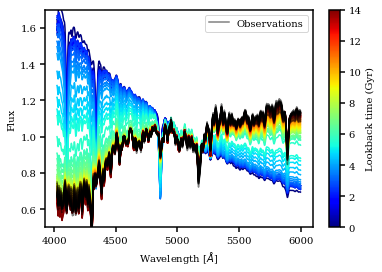

In [38]:
#last check

print(np.shape(fluxes_MILES[0,:]))

w=np.copy(waves_short_2[0])

#MILES
colors=plt.cm.jet(np.linspace(0,1,len(tbins)))
for i in range(len(fluxes_MILES[:,0])):
    plt.plot(w,fluxes_MILES[i,:]/np.median(fluxes_MILES[i,:]),color=colors[i])
    plt.scatter(w,fluxes_MILES[i,:],marker='None',c=tbins[i]*np.ones(len(w)),cmap='jet')
    
#observations
for i in range(n):
    if i==0:
        plt.plot(w,fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k',label='Observations',alpha=0.5)
    else:
        plt.plot(w,fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k',alpha=0.5)
        
    
        
plt.colorbar(label='Lookback time (Gyr)')
plt.clim(0,14)
plt.ylim(0.5,1.7)
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()

#observations are really old galaxies as we see



In [47]:
"""#MILES before interpolation
print(wave_short)
print(spec_conv_short[-1]/np.median(spec_conv_short[-1]))

#MILES after interpolation
print(w)
print(fluxes_MILES[-1,:]/np.median(fluxes_MILES[-1,:]))

#observations
print(w)
print(fluxes_conv_2[0]/np.median(fluxes_conv_2[0]))"""

#Now try to get the age

differences=np.zeros((53,))

#first observation
f=fluxes_conv_2[0]/np.median(fluxes_conv_2[0])

for i in range(53):
    diff=np.abs(fluxes_MILES[i,:]/np.median(fluxes_MILES[i,:])-f)
    differences[i]=np.sum(diff)

#print('Age first observation: ',tbins[np.argmin(differences)],' Gyr')

#print(tbins)

#now all the observations as if they were SSPs
ages=[]
for j in range(n):
    differences=np.zeros((53,))
    f=fluxes_conv_2[j]/np.median(fluxes_conv_2[j])
    for i in range(53):
        diff=np.abs(fluxes_MILES[i,:]/np.median(fluxes_MILES[i,:])-f)
        differences[i]=np.sum(diff)
    print('Age observation: ',tbins[np.argmin(differences)],' Gyr')
    ages.append(tbins[np.argmin(differences)])
    



Age observation:  7.0  Gyr
Age observation:  8.0  Gyr
Age observation:  8.0  Gyr
Age observation:  9.5  Gyr
Age observation:  11.0  Gyr
Age observation:  11.5  Gyr
Age observation:  12.0  Gyr
Age observation:  12.0  Gyr
Age observation:  12.0  Gyr
Age observation:  12.0  Gyr
Age observation:  12.0  Gyr
Age observation:  14.0  Gyr
Age observation:  14.0  Gyr
Age observation:  14.0  Gyr
Age observation:  14.0  Gyr
Age observation:  14.0  Gyr
Age observation:  14.0  Gyr
Age observation:  14.0  Gyr
